<a href="https://colab.research.google.com/github/allenhjw/DeepLearning/blob/main/Mask_RCNN_PretrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialise the google drive
Mounted on google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Initialise the working directories
User define the path directory, folders and model name.

In [ ]:
import os
from pathlib import Path

dll_path=Path('/content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/')
dll_img='01_img'
dll_mask='02_mask'
model_saveDIR=Path('/content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/02_model/')
model_Name='Pre_train_DENSE_RCNN_29SEP_RandSEEd.sav'
model_save=os.path.join(model_saveDIR,model_Name)
src_file_path=Path('/content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/00_code/00_src')


### Get neccessary soruce files.
Copy the source files to the files.

In [ ]:
%%shell

cd drive

cp MyDrive/src/utils.py ../
cp MyDrive/src/Model_inst_ultis.py ../
cp MyDrive/src/img_dataload_util.py ../
cp MyDrive/src/rcnn_utils.py ../
cp MyDrive/src/transforms.py ../


[NOTE:] Not important. For testing purposes

In [ ]:
a=os.path.join(dll_path,'data',dll_img)
print(a)

/content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/data/01_img


### Create random seed for the machine reproducibility
Randomise the seed number. User can set the random seed as well. Default approach is to randomise the seed number

In [ ]:
import random
import torch

# Set random seed for reproducibility
manualSeed = random.randint(1, 10000) 
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  4581


### Training the model
Function to prepare the data and train the model

In [ ]:
import img_dataload_util
import Model_inst_ultis
import utils
import joblib
import torch
import os
#cfg_DataDir = dll_path
cfg_device='cuda'

def main(dll_DIR,dll_folder):
  print('Start run RCNN!!!')
    
    # set up the dataloader (dll)
  dll_ut=img_dataload_util.dataLoad(SourcePH=dll_path,SourceDir='data',device=cfg_device)

  # ------------ Mask if not in use
  # Data Augmentation
  #lg.info('Data is augmentated by rotation!!!')
  #dll_ut._data_AUG()
  #_data_AUG(os.path.join(dll_path,'01_Data'))
  # ------------

  IMG_ph=os.path.join(dll_DIR,dll_folder,'01_img')
  print('Image database location {}',format(IMG_ph))
  MSK_ph=os.path.join(dll_DIR,dll_folder,'02_mask')
  # get load path
  #IMG_ph,MSK_ph=dll_ut._getLoadpath()
  print('Mask database location {}',format(MSK_ph))
  #print(IMG_ph)
  dll_info_ut=img_dataload_util.roiinfo(imgSourceLP=IMG_ph,MaskSourceLP=MSK_ph,data_transf=None)
  print('Load data into loader!!!')
  full_trg=dll_ut.dataloader(dll_info_ut) # without data augmentation

  #trg_Data,val_Data,Test_data=dll_ut.TVT_split(dll_info_ut,[0.6,0.6])
    
  # set up the Model (mdl)
  numclass=2 # we assume we wants to classify.
  mdl_ut=Model_inst_ultis.model_instance(pre_trained=True)
  #mdl=mdl_ut._get_instance_segModel(numclass)
  mdl=mdl_ut._use_Backmodel(numclass)
  mdl.to(cfg_device)

  # construct an optimizer
  params = [p for p in mdl.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.0001,
                              momentum=0.9, weight_decay=0.0001) #change weight_decay=0.001
  # and a learning rate scheduler
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                 step_size=2,
                                                 gamma=0.005) #change step_size=3;gamma=0.01

  # NOTE: train the model start from here.
    
  print('Load data into loader!!!')
  num_epochs = 15
  mdl.to(cfg_device)
  mdl.train()
    
  ##
  for epoch in range(num_epochs):
    BatchNUM=0
        
    #lr_scheduler = None 
    if epoch == 0:
      warmup_factor = 1.0 / 1000
      warmup_iters = min(1000, len(full_trg) - 1)
      lr_scheduler = torch.optim.lr_scheduler.LinearLR(
          optimizer, start_factor=warmup_factor, total_iters=warmup_iters)
      
    for trg_img ,trg_info in full_trg.__iter__(): # use all the data set to train the NN
      BatchNUM+=1
      optimizer.zero_grad()
      # mount to device
      trg_img_ondevice=list(m.squeeze(0).to(cfg_device) for m in trg_img)
      trg_info_ondvice = [{k: v.to(cfg_device) for k, v in t.items()} for t in trg_info]
                
      loss_dict = mdl(trg_img_ondevice, trg_info_ondvice)
      losses = sum(loss for loss in loss_dict.values()) # for scalar

      # reduce losses over all GPUs for logging purposes
      loss_dict_reduced = utils.reduce_dict(loss_dict)
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())

      loss_value = losses_reduced.item()
      print ('Epoch:{} | BatchNum: {} | Reduce loss: {} | loss_box_reg:{}'.format(str(epoch),str(BatchNUM),str(loss_value),str(loss_dict_reduced['loss_box_reg'].item())))
            
      losses.backward()
      optimizer.step()

      #lr_scheduler.step()
      #if lr_scheduler is not None:
      lr_scheduler.step()
      # update the learning rate
        #lr_scheduler.step()
        # evaluate on the test dataset
        #evaluate(mdl, val_Data, device=cfg_device)
  print('Training complete!!!')
    #-print("That's it, Training complete!")
  print ('Model is saved at{}',format(model_save))
  joblib.dump(mdl,model_save)
    

### Image Augmentation
The image is flipped or rotate 180 degree.

[NOTE:] we will move this to another computer vision algorithm. 

In [ ]:
import os
from PIL import Image
def _data_AUG(root_DIR):
  img_list=os.listdir(os.path.join(root_DIR,'img'))
  for img in img_list:
    IMG=Image.open(os.path.join(root_DIR,'img',img))
    IMG = IMG.rotate(180)
    IMG.save(os.path.join(root_DIR,'img','r180-'+img))
    # opne the mask
    fileNameHead=img.split('.')[0]
    maskname=fileNameHead+'_mask.png' # file extension can be in the config
    mask=Image.open(os.path.join(root_DIR,'mask',maskname))
    mask=mask.rotate(180)
    mask.save(os.path.join(root_DIR,'mask','r180-'+maskname))

[NOTE:] not in use

In [ ]:
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Run the main function
Execute the main function to train the model.

In [ ]:
main(dll_path,'01_Data')

Start run RCNN!!!
Image database location {} /content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/01_Data/01_img
Mask database location {} /content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/01_Data/02_mask
Load data into loader!!!


Load pre-trained model to predict 

In [ ]:
p

### Infer the mask using the trained model.

In [ ]:
import img_dataload_util
import Model_inst_ultis
import utils
import joblib
import torch
import rcnn_utils
import os

imageNUM=0
#cfg_DataDir = dll_path
cfg_mdlSAVE=os.path.join(dll_path,'02_model')
cfg_device='cuda'
dll_ut=img_dataload_util.dataLoad(SourcePH=dll_path,SourceDir='data',device=cfg_device)
Test_IMG_ph=os.path.join(dll_path,'01_Data','01_img')
print('Image database location {}',format(Test_IMG_ph))
MSK_ph=os.path.join(dll_path,'01_Data','02_mask')
# get load path
#IMG_ph,MSK_ph=dll_ut._getLoadpath()
print('Mask database location {}',format(MSK_ph))
dll_info_ut=img_dataload_util.roiinfo(imgSourceLP=Test_IMG_ph,MaskSourceLP=MSK_ph,data_transf=None)
full_trg=dll_ut.dataloader(dll_info_ut) # without data augmentation
trg_Data,val_Data,Test_data=dll_ut.TVT_split(dll_info_ut,[0.6,0.6])
img,_=Test_data[imageNUM]
mdl_name='Pre_train_RCNN.sav'
rcnn_eval=rcnn_utils.RCNNmdl_eval(cfg_mdlSAVE,mdl_name,img,cfg_device)
pred=rcnn_eval.mdl_eval()
imgA=rcnn_eval.visual_img(img,pred,'img') # display the image
box=rcnn_eval.visual_img(img,pred,'bbox')
mask=rcnn_eval.visual_img(img,pred,'pred')
# Get the actual image name.
imageInd=Test_data[imageNUM][1]['image_id'].numpy()
img_name=Test_data.dataset.imgslist[int(imageInd)]

Image database location {} /content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/01_Data/01_img
Mask database location {} /content/drive/MyDrive/00 ML Project/02 [Project] WSI extraction/01_Data/02_mask


### Open the actual mask
The purpose is to compare the prediction mask with the actual mask

In [ ]:
import os
from PIL import Image 
#imgA,_=Test_data[0]
#a=Test_data[0][1]['image_id'].numpy()
#Test_data.dataset.imgslist[43]
img_name
# get mask
img_name_split=img_name.split('.')[0]
maskname_ph=img_name_split+'_mask.png'
mask_load_ph=os.path.join(dll_path,'01_Data','02_mask',maskname_ph)
save_img=os.path.join(dll_path,'01_Data','05_ForCV','actualMASK.png')
msk=Image.open(mask_load_ph)
msk.save(save_img)
msk

### Show the actual image


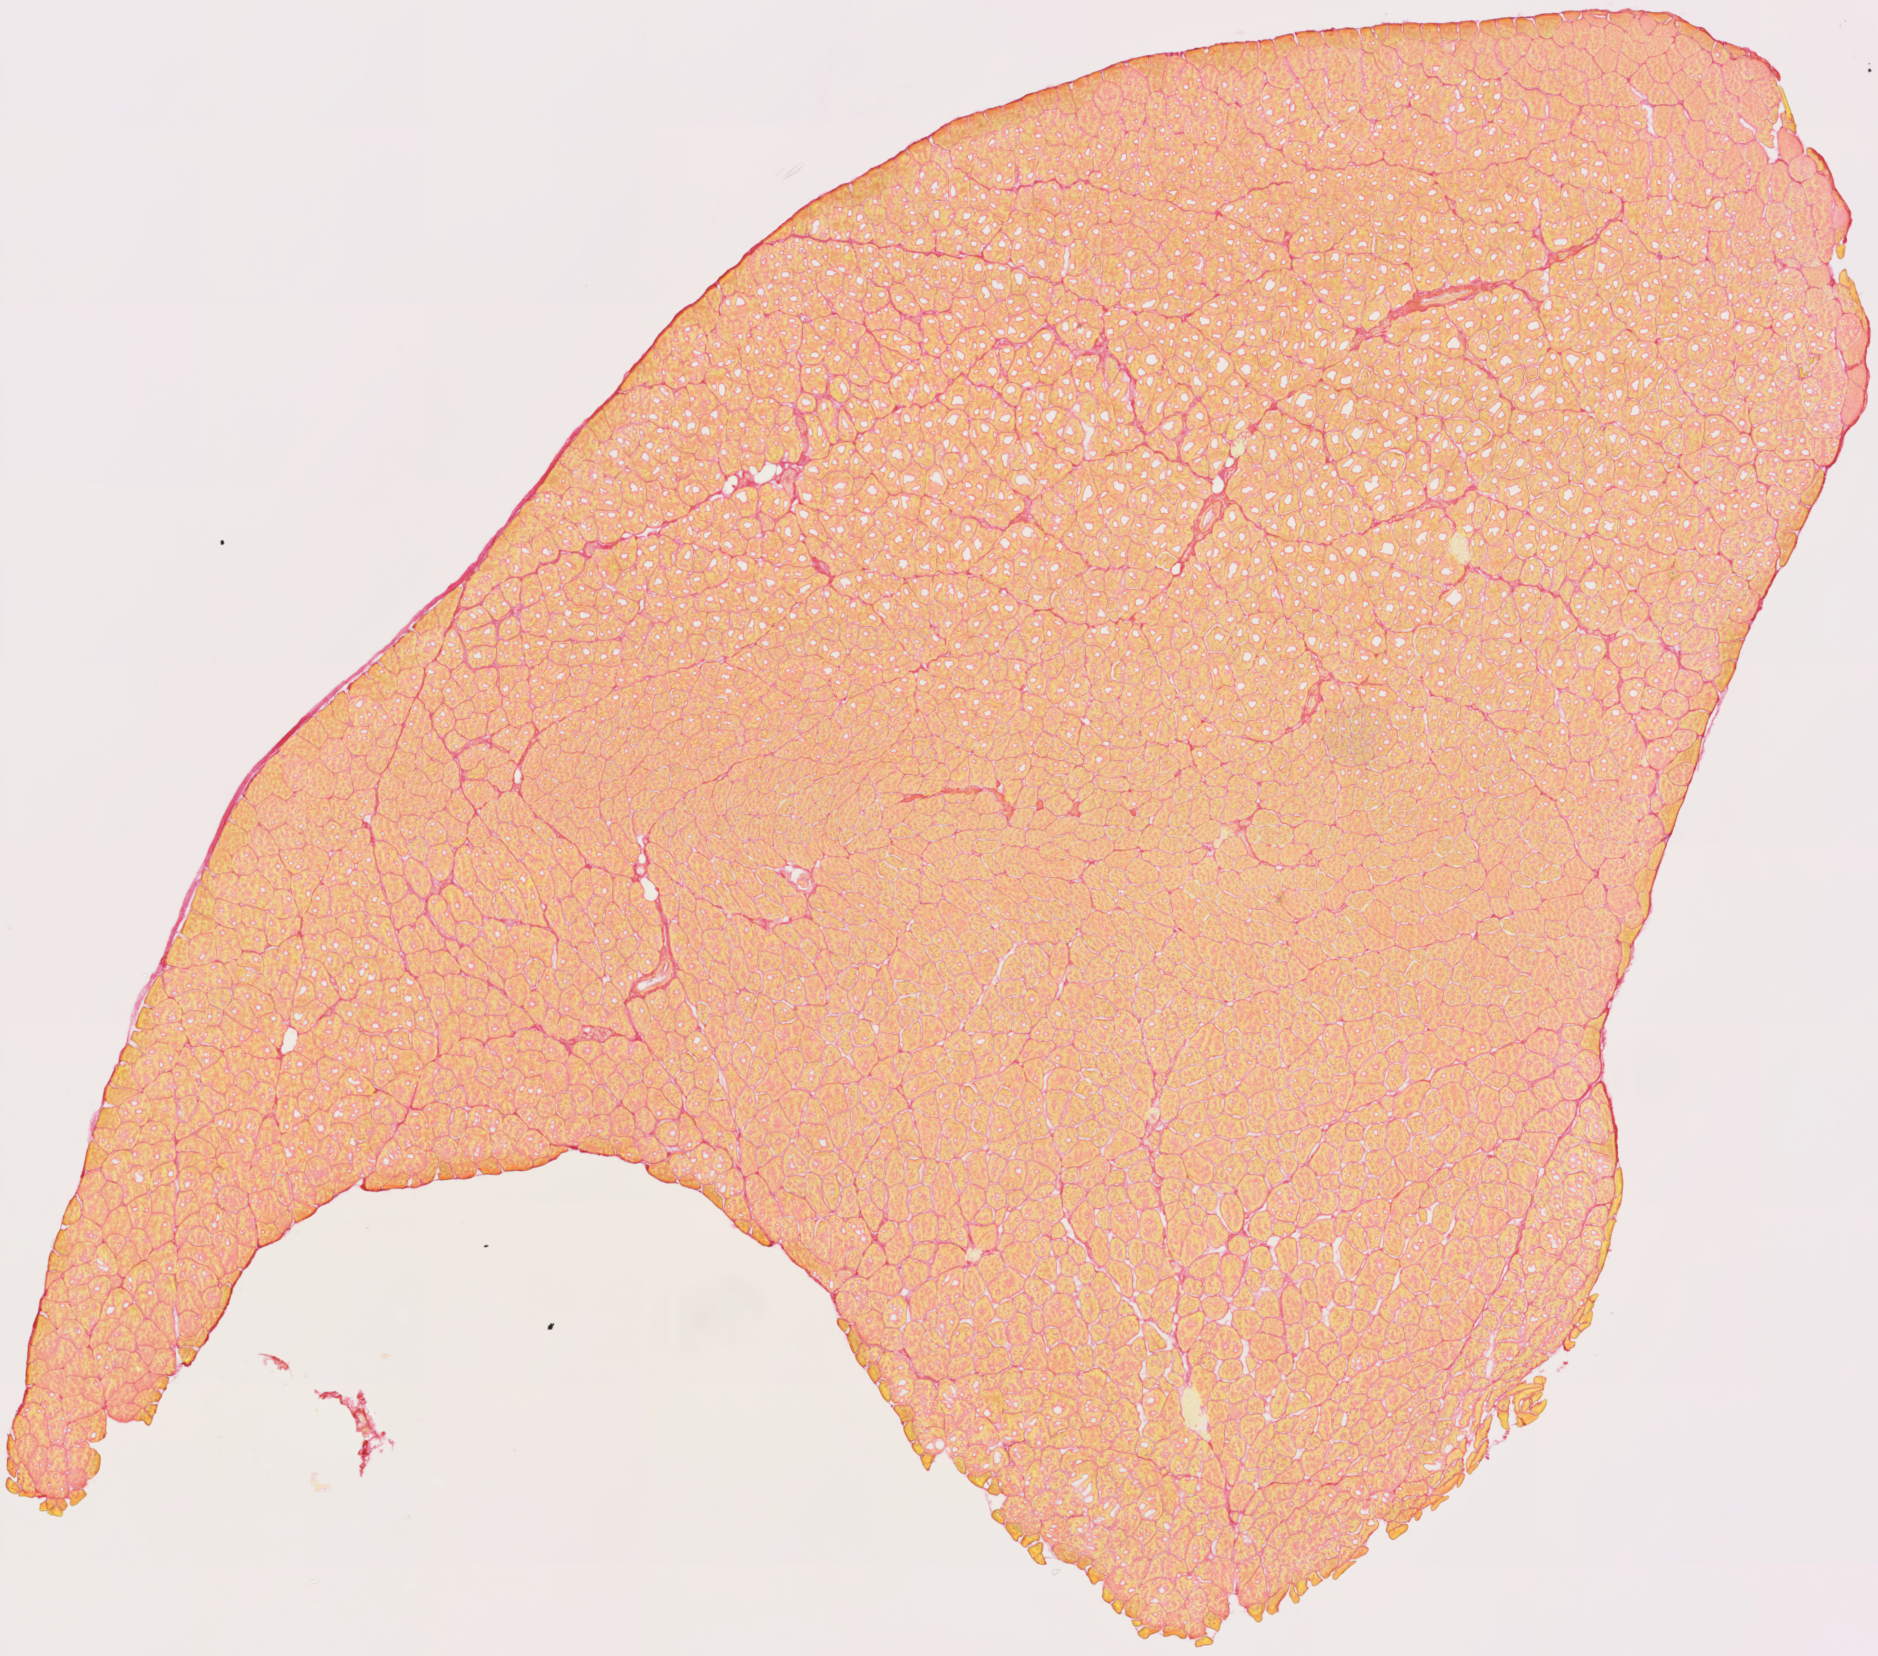

In [ ]:
from PIL import Image
img=img.squeeze()
imgB=Image.fromarray(img.mul(255).permute(1,2,0).byte().numpy())
save_img=os.path.join(dll_path,'01_Data','05_ForCV','ori_img.png')
imgB.save(save_img)
imgB

### Show the predicted mask

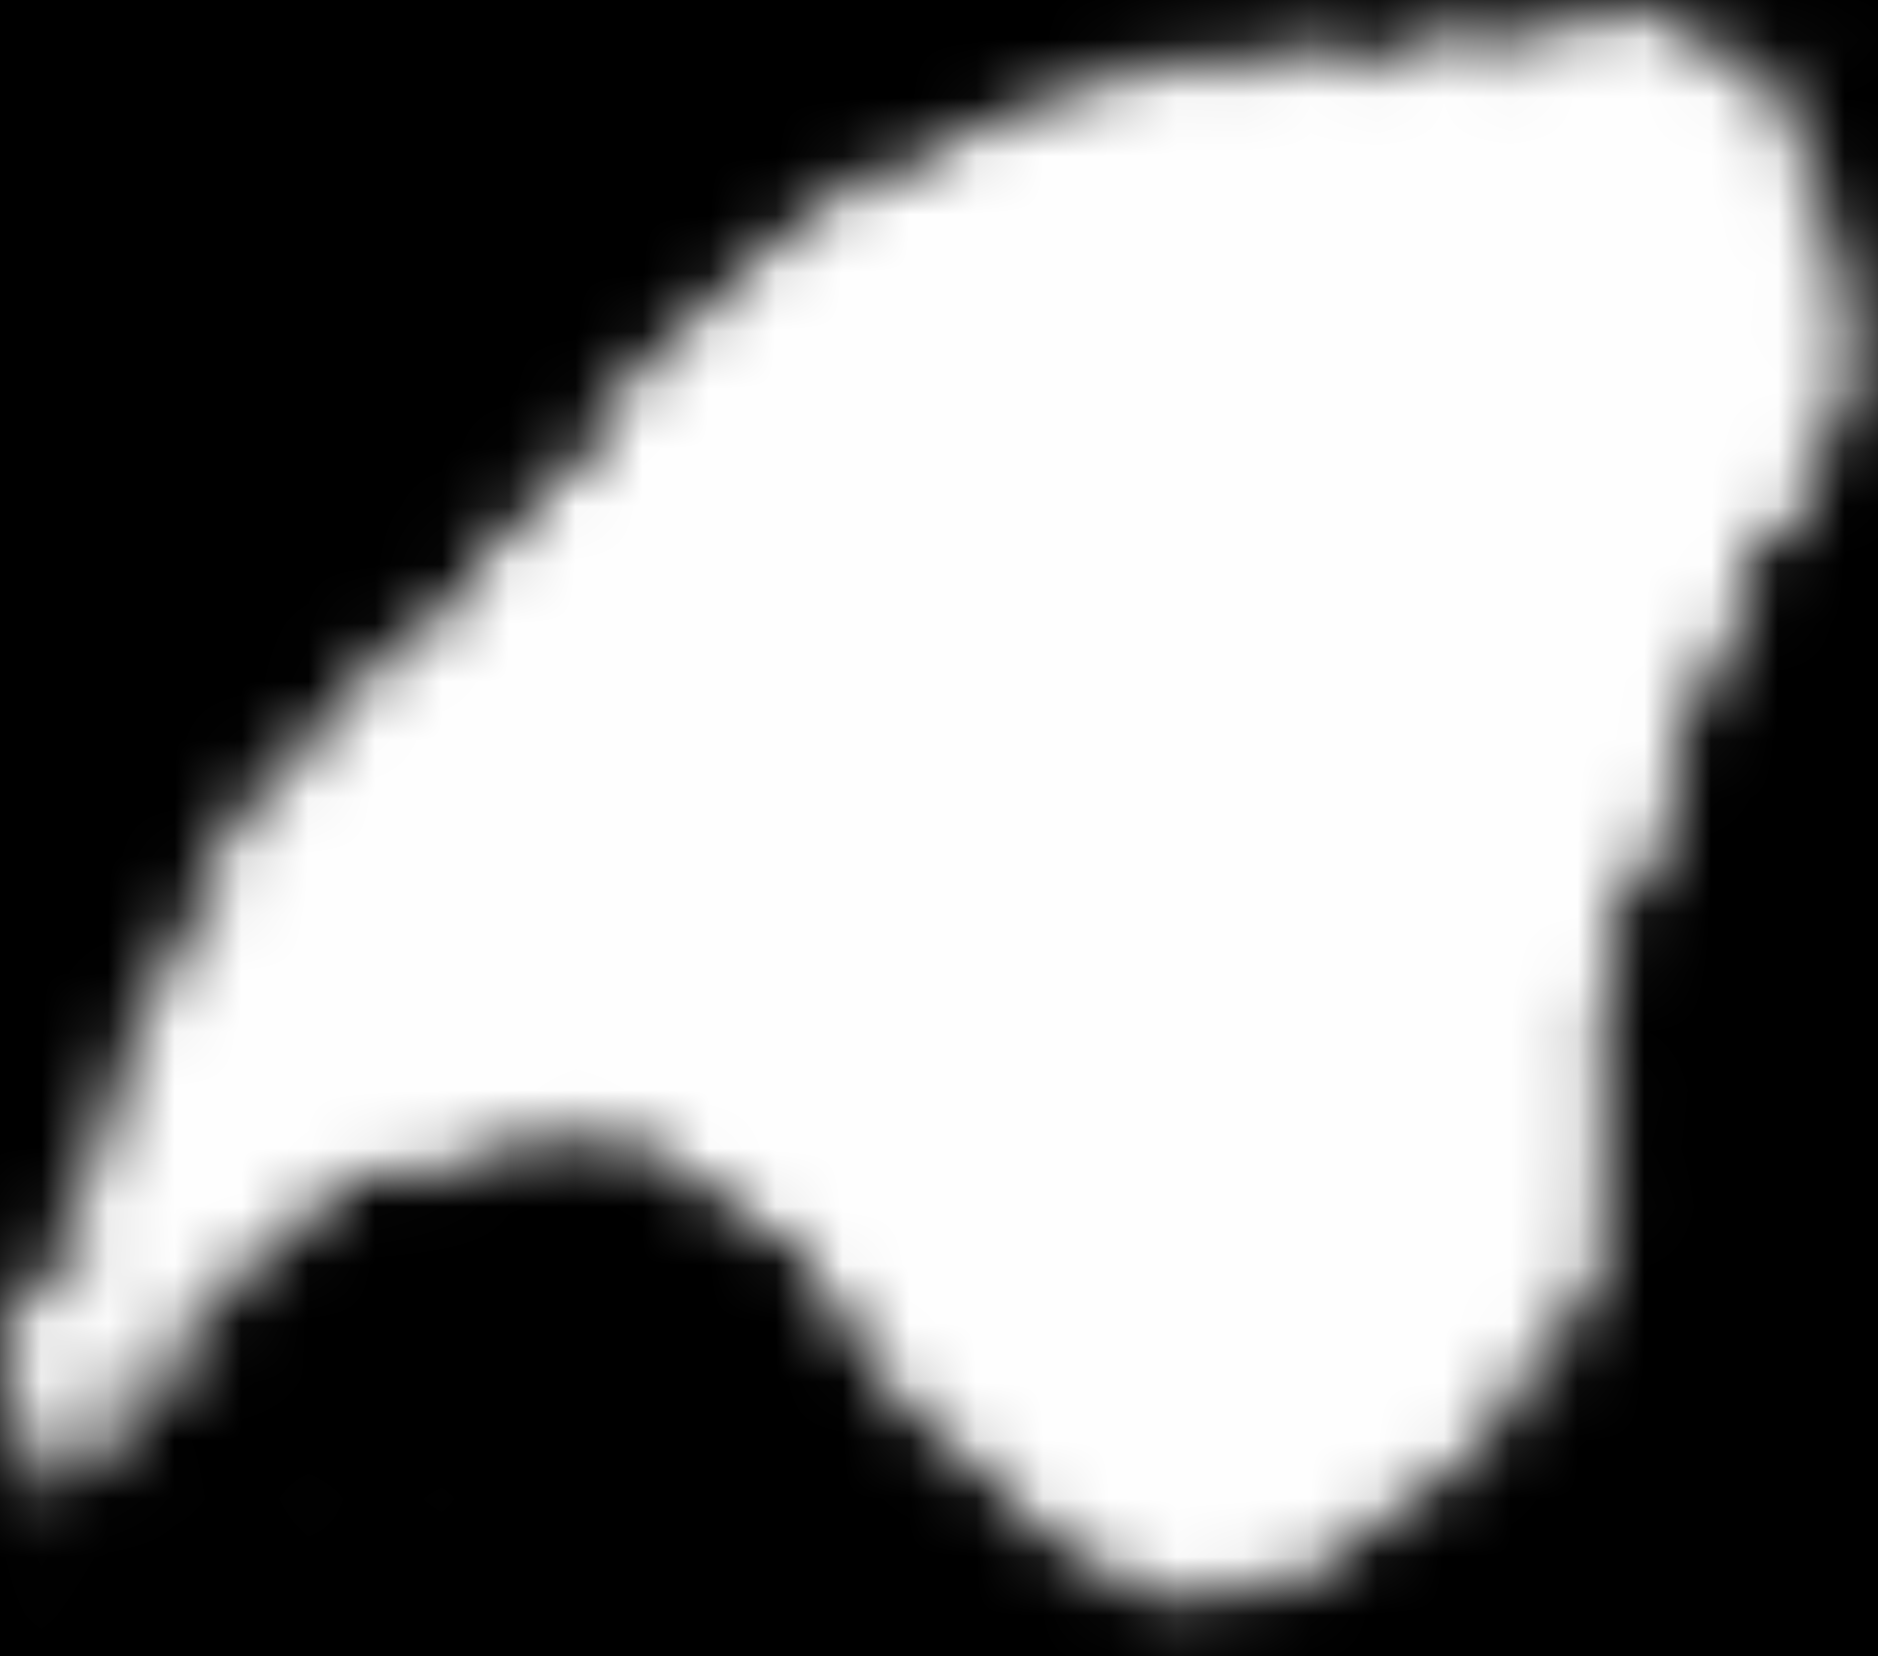

In [ ]:
P_mask=Image.fromarray(pred[0]['masks'][0,0].mul(255).byte().cpu().numpy()) 
save_img=os.path.join(dll_path,'01_Data','05_ForCV','pred_mask.png')
P_mask.save(save_img)
P_mask